Comenzando cargando las librerías necesarias

In [1]:
import matplotlib.pyplot
import numpy
import pandas
import random
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.tree
import xgboost

A continuación definimos algunas funciones de utilidad y cargamos el conjunto de datos discretizado.

In [48]:
# Definición de función para discretizar variables por cuantiles
def DiscretizarPorCuantiles(datos, columnas, intervalos):
    datosNuevos = datos.copy()
    informacion = {}
    for columna in columnas:
        paso      = 1 / intervalos
        cuantiles = numpy.arange(0, 1.0 + paso, paso)
        etiquetas = list(map(str, numpy.arange(1, intervalos + 1)))

        (nuevosDatos, intervalosEtiquetas) = pandas.qcut(x=datos[columna], q=cuantiles, labels=etiquetas, retbins=True)
        datosNuevos[columna] = nuevosDatos.cat.codes
        informacion[columna] = { "cuantiles": cuantiles, "etiquetas": etiquetas, "intervalos": intervalosEtiquetas }
    return [datosNuevos, informacion ]

# Definición de función para calcular métricas a partir de un modelo
def CalcularMetricas(observaciones, predicciones):
    matriz_confusion = sklearn.metrics.confusion_matrix(observaciones, predicciones)
    metricas  = {
        "accuracy": sklearn.metrics.accuracy_score(observaciones, predicciones),
        "roc_auc": sklearn.metrics.roc_auc_score(observaciones, predicciones),
        "precision": sklearn.metrics.precision_score(observaciones, predicciones),
        "recall": sklearn.metrics.recall_score(observaciones, predicciones),
        "f1": sklearn.metrics.f1_score(observaciones, predicciones),
        "TP": matriz_confusion[1, 1],
        "FP": matriz_confusion[0, 1],
        "TN": matriz_confusion[0, 0],
        "FN": matriz_confusion[1, 0]        
    }
    return metricas  

# Función para entrenrar un modelos y explorar parámetros utilizando k-Fold Cross Validation
def EvaluarPerformance(gridSearch, parametros):
    # Generar DataFrame de resultados
    resultadosDF  = []
    resultados    = gridSearch.cv_results_
    combinaciones = resultados["params"]    
    for i in range(0, gridSearch.n_splits_):
        keyName = "split" + str(i) + "_test_score"
        if keyName in resultados:
            valores = resultados[keyName]
            for j in range(0, len(combinaciones)):
                datosCombinacion = [ i ]
                datosCombinacion.append(valores[j])
                for parametro in parametros.keys():
                    datosCombinacion.append(combinaciones[j][parametro])
                resultadosDF.append(datosCombinacion)

    columnas  = ["k", "valor"]
    columnas.extend(parametros.keys())
    groupcols = list(parametros.keys())
    resultadosDF = pandas.DataFrame.from_records(resultadosDF, columns=columnas)\
        .groupby(groupcols, as_index=False)\
        .aggregate({'valor':{'media':'mean', 'desvio':'std'}})
    return resultadosDF

# Lectura de set de datos discretizado
setDatosOriginal = pandas.read_csv(filepath_or_buffer = "input/SetDatosDiscretizado.csv", sep = "\t",
                                       na_values = "NA")
setDatosDiscretizado, informacion = DiscretizarPorCuantiles(datos=setDatosOriginal, columnas=['age','height','weight'], intervalos=10)

# Separo los features del data frame del target a aprender
atributos = setDatosDiscretizado.drop(columns = [ "id", "cardio" ])
objetivo  = setDatosDiscretizado['cardio']


Luego, separamos el conjunto de datos en conjunto de *desarrollo* y conjunto de *test*

In [3]:
# Separar en sets de desarrollo (entrenamiento + validacion) y testeo
atributosDesarrollo, atributosTest, objetivoDesarrollo, objetivoTest = \
    sklearn.model_selection.train_test_split(atributos, objetivo, train_size = 0.8, test_size = 0.2, random_state = 0)

# Separar el set de desarrollo en sets de entrenamiento y validacion
atributosEntrenamiento, atributosValidacion, objetivoEntrenamiento, objetivoValidacion = \
    sklearn.model_selection.train_test_split(atributosDesarrollo, objetivoDesarrollo,
                                             train_size = 0.8, test_size = 0.2, random_state = 0)

# 1. Clasificación utilizando *Random Forest*

In [65]:
clasificadorRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
                                                                   criterion="gini", 
                                                                   max_depth=6,                                                                    
                                                                   random_state=0)

A continuación, exploramos parámetros del clasificador utilizando 5-Fold Cross Validation.

In [69]:
parametrosRF = { "max_features": numpy.arange(1, len(atributosDesarrollo.columns)+1) }
gridSearchRF = sklearn.model_selection.GridSearchCV(estimator = clasificadorRandomForest, cv = 5, n_jobs = 2, 
                                                    param_grid = parametrosRF, scoring = 'roc_auc',
                                                    return_train_score=False)
gridSearchRF.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceRF = EvaluarPerformance(gridSearchRF, parametrosRF)
print(performanceRF)

   max_features     valor          
                    media    desvio
0             1  0.790919  0.004844
1             2  0.795744  0.004582
2             3  0.797641  0.004382
3             4  0.798160  0.004279
4             5  0.798666  0.004281
5             6  0.798671  0.003969
6             7  0.798636  0.003997
7             8  0.798507  0.003982
8             9  0.798399  0.004051
9            10  0.798280  0.004070
10           11  0.798380  0.004134


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Ahora calculamos métricas utilizando el conjunto de test.

In [70]:
prediccionesRF = gridSearchRF.best_estimator_.predict(atributosTest)
metricasRF     = CalcularMetricas(objetivoTest, prediccionesRF)
print(metricasRF)

{'accuracy': 0.7328571428571429, 'roc_auc': 0.7320735184085948, 'precision': 0.7725021349274125, 'recall': 0.6525753859471938, 'f1': 0.7074925699984359, 'TP': 4523, 'FP': 1332, 'TN': 5737, 'FN': 2408}


Finalmente, graficamos la importancia de cada uno de los atributos a los efectos del ajuste según los resultados devueltos por el clasificador *Random Forest*.

/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


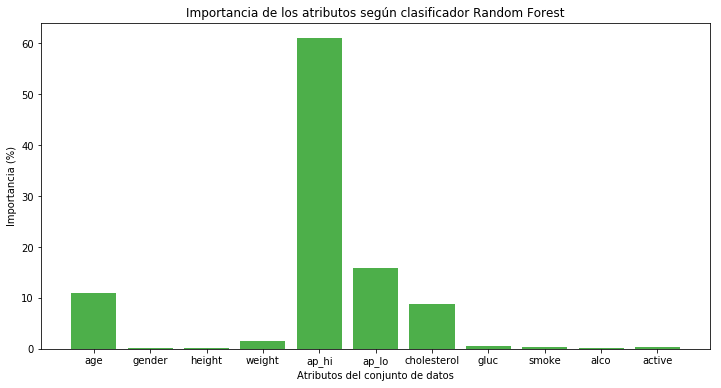

In [71]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * gridSearchRF.best_estimator_.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY, color="#4daf4a")
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Random Forest')
figura.show()

# 2. Clasificación utilizando *Gradient Boosting* (XGBoost)

In [59]:
clasificadorXGBoost = xgboost.XGBClassifier(n_estimators=100,
                                            max_depth=6,
                                            objective='binary:logistic',
                                            seed=0)

Calculamos meétricas utilizando el conjunto de test

In [72]:
parametrosXGB = { "learning_rate": [ 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5 ] }
gridSearchXGB = sklearn.model_selection.GridSearchCV(estimator = clasificadorXGBoost, cv = 5, n_jobs = 2, 
                                                    param_grid = parametrosXGB, scoring = 'roc_auc',
                                                    return_train_score=False)
gridSearchXGB.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceXGB = EvaluarPerformance(gridSearchXGB, parametrosXGB)
print(performanceXGB)

   learning_rate     valor          
                     media    desvio
0           0.01  0.798375  0.003598
1           0.05  0.801059  0.003707
2           0.10  0.800264  0.003501
3           0.15  0.799454  0.003026
4           0.20  0.798617  0.003436
5           0.25  0.797357  0.003328
6           0.30  0.795305  0.002724
7           0.35  0.794401  0.002494
8           0.40  0.792579  0.003153
9           0.45  0.792180  0.002867
10          0.50  0.789100  0.003079
11          0.60  0.786709  0.002963
12          0.70  0.783990  0.003091
13          0.80  0.779745  0.003353
14          0.90  0.775984  0.001329
15          1.00  0.771931  0.002868


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Buscamos la totalidad de las métricas para el mejor clasificador utilizando el conjunto de test.

In [81]:
prediccionesXGB = gridSearchXGB.best_estimator_.predict(atributosTest)
metricasXGB     = CalcularMetricas(objetivoTest, prediccionesXGB)
print("Mejor ajuste: ", gridSearchXGB.best_params_)
print("Métricas para el mejor ajuste: ", metricasXGB)

Mejor ajuste:  {'learning_rate': 0.05}
Métricas para el mejor ajuste:  {'accuracy': 0.7353571428571428, 'roc_auc': 0.7348223263080725, 'precision': 0.7598260309278351, 'recall': 0.6805655749531092, 'f1': 0.718015069640003, 'TP': 4717, 'FP': 1491, 'TN': 5578, 'FN': 2214}


Graficamos la importancia de los features, según este clasificador.

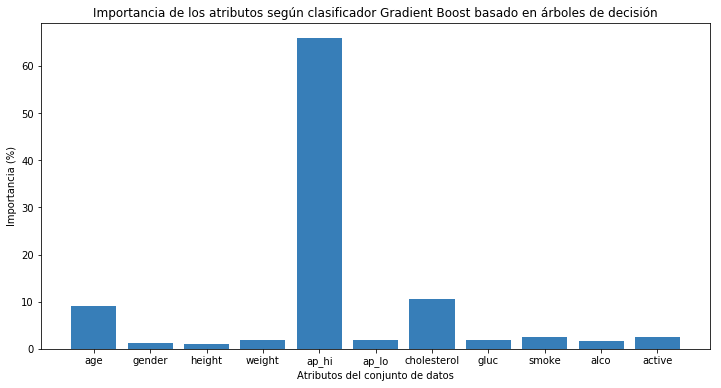

In [104]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * gridSearchXGB.best_estimator_.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY, color="#377eb8")
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Gradient Boost basado en árboles de decisión')
figura.show()

Antes de pasar al próximo clasificador, comparamos la importancia que los dos clasificadores evaluados le dan a cada uno de los atributos de entrada.

Text(0.5, 1.0, 'Comparativa de importancia de atributos entre modelos basandos en ensamble')

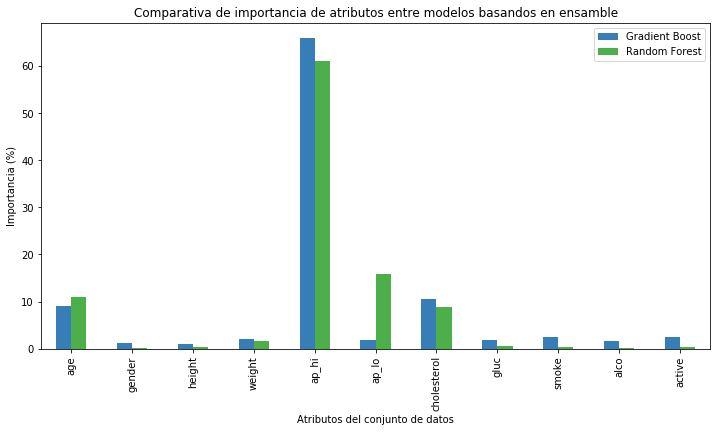

In [121]:
valoresZ    = 100 * gridSearchRF.best_estimator_.feature_importances_
comparativa = pandas.DataFrame(numpy.c_[valoresX, valoresY, valoresZ], index=valoresX)
comparativa.columns = [ "Atributo", "Gradient Boost", "Random Forest" ]
panel = comparativa.plot.bar(figsize = (12, 6), color=("#377eb8", "#4daf4a"))
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Comparativa de importancia de atributos entre modelos basandos en ensamble')

# 3. Clasificación utilizando *Ada Boosting* con *Naïve Bayes*

In [54]:
estimadorBase        = sklearn.naive_bayes.GaussianNB()
clasificadorAdaBoost = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
                                                           base_estimator=estimadorBase,
                                                           random_state=0)

Exploramos parámetros del clasificador (en este caso, solamente *learning_rate*) utilizando 5-Fold Cross Validation

In [82]:
parametrosAB = { "learning_rate": [ 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ] }
gridSearchAB = sklearn.model_selection.GridSearchCV(estimator = clasificadorAdaBoost, cv = 5, n_jobs = 2, 
                                                    param_grid = parametrosAB, scoring = 'roc_auc',
                                                    return_train_score=False)
gridSearchAB.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceAB = EvaluarPerformance(gridSearchAB, parametrosAB)
print(performanceAB)

   learning_rate     valor          
                     media    desvio
0           0.01  0.788062  0.004033
1           0.05  0.790049  0.003528
2           0.10  0.790519  0.003448
3           0.15  0.790523  0.003449
4           0.20  0.769274  0.015576
5           0.25  0.729537  0.005640
6           0.30  0.725133  0.006216
7           0.35  0.712001  0.017185
8           0.40  0.689090  0.034742
9           0.45  0.613003  0.029389
10          0.50  0.611635  0.063441
11          0.60  0.583241  0.013525
12          0.70  0.605745  0.073554
13          0.80  0.527156  0.053175
14          0.90  0.532357  0.073666
15          1.00  0.638936  0.071588


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Obtenemos todas las métricas del mejor clasificador utilizando el conjunto de *test*

In [83]:
prediccionesAB = gridSearchAB.best_estimator_.predict(atributosTest)
metricasAB     = CalcularMetricas(objetivoTest, prediccionesAB)
print("Mejor ajuste: ", gridSearchAB.best_params_)
print("Métricas para el mejor ajuste: ", metricasAB)

Mejor ajuste:  {'learning_rate': 0.15}
Métricas para el mejor ajuste:  {'accuracy': 0.7271428571428571, 'roc_auc': 0.7266304793410642, 'precision': 0.7492389040217914, 'recall': 0.6746501226374261, 'f1': 0.7099908897661706, 'TP': 4676, 'FP': 1565, 'TN': 5504, 'FN': 2255}


Es interesante observar al valor medio de la métrica *ROC AUC* en función del valor de *learning_rate*.

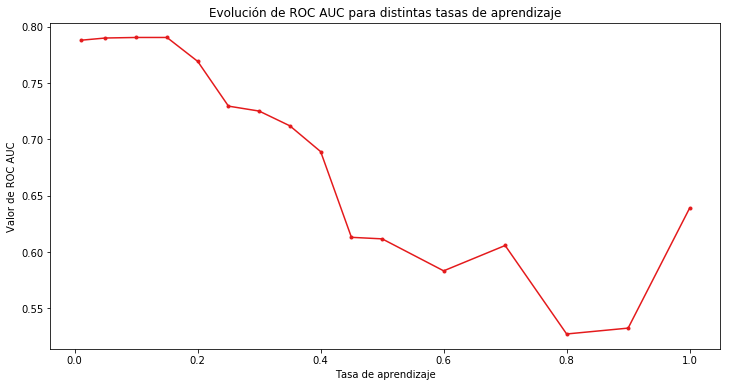

In [96]:
valoresX = list(performanceAB['learning_rate'])
valoresY = list(performanceAB['valor']['media'])
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.plot(valoresX, valoresY, '.-', color="#e41a1c")
panel.set_xlabel('Tasa de aprendizaje')
panel.set_ylabel('Valor de ROC AUC')
panel.set_title('Evolución de ROC AUC para distintas tasas de aprendizaje')
figura.show()